In [2]:
import splitfolders  # or import split_folders

# Split dengan ratio.
# Untuk hanya membagi menjadi set pelatihan dan validasi, setel tuple menjadi `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("dataset", output="data", seed=1337, ratio=(.8,.2), group_prefix=None)

In [5]:

from keras_facenet import FaceNet

In [9]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'data'.
There are 3 directories and 0 images in 'data\train'.
There are 0 directories and 80 images in 'data\train\abizar'.
There are 0 directories and 80 images in 'data\train\bintang'.
There are 0 directories and 80 images in 'data\train\muchdor'.
There are 3 directories and 0 images in 'data\val'.
There are 0 directories and 20 images in 'data\val\abizar'.
There are 0 directories and 20 images in 'data\val\bintang'.
There are 0 directories and 20 images in 'data\val\muchdor'.


In [10]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "data/train/"
test_dir = "data/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 240 images belonging to 3 classes.
Testing images:
Found 60 images belonging to 3 classes.


In [12]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [13]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

In [14]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [15]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [17]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data)) # name of log files

Epoch 1/5
8/8 [==============================] - 38s 4s/step - loss: 0.5214 - accuracy: 0.8708 - val_loss: 0.1011 - val_accuracy: 1.0000
Epoch 2/5
8/8 [==============================] - 32s 4s/step - loss: 0.0484 - accuracy: 1.0000 - val_loss: 0.0164 - val_accuracy: 1.0000
Epoch 3/5
8/8 [==============================] - 33s 4s/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 4/5
8/8 [==============================] - 27s 3s/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 5/5
8/8 [==============================] - 25s 3s/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000


In [18]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


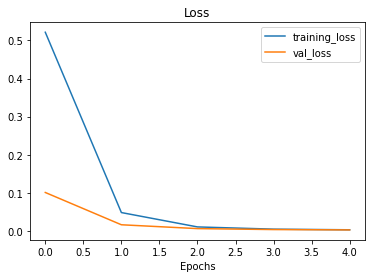

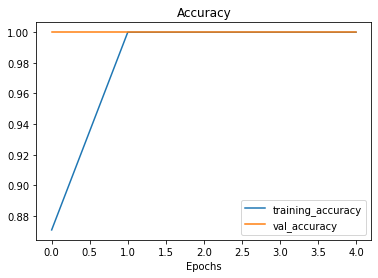

In [19]:
plot_loss_curves(resnet_history)

In [20]:
# Resnet summary 
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 3)                 6147      
                                                                 
Total params: 23,570,947
Trainable params: 6,147
Non-trainable params: 23,564,800
_________________________________________________________________


In [22]:
results_feature_extraction_model = resnet_model.evaluate(test_data)

2/2 [==============================] - 7s 3s/step - loss: 0.0029 - accuracy: 1.0000


In [24]:
resnet_model.save("model.h5")